# Митрофанов Антон Андрееви
## Работа #1
Develop a bundle of VAE and GAN to recover numbers from the MNIST dataset. In this case, VAE and GAN are not separate neural networks, but form a single pipeline with a triplex loss function


In [1]:
# будем использовать torch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# подготавливаем MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
batch_size = 256

train_dataset = datasets.MNIST(root='./data/', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15762657.39it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 480455.06it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4420074.33it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10873589.48it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:

# VAE + GAN model
class VAE_GAN(nn.Module):
    def __init__(self):
        super(VAE_GAN, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400, 600),
            nn.ReLU(),
            nn.Linear(600, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 100),
            nn.ReLU()
        )

        # Latent space
        self.mu = nn.Linear(100, 100)
        self.log_var = nn.Linear(100, 100)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Tanh()
        )

        # Discriminator
        self.discriminator = nn.Sequential(
            nn.Linear(784, 200),
            nn.ReLU(),
            # nn.Linear(400, 200),
            # nn.ReLU(),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        log_var = self.log_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return self.decoder(z)

    def discriminate(self, z):
        return self.discriminator(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return mu, log_var, z, x_recon


triplet_mul_every_epoch=1.0000771846018068, disc_mul_every_epoch=1.0528011937674224
Epoch [1/180], Step [100/235], Loss: 0.2698962986469269, kl_div=0.5323044061660767, disc=0.8133077025413513, disc_up=1.177018404006958, triplet=0.7621041536331177, tw=1e-06, mse=0.26928189396858215
Epoch [1/180], Step [200/235], Loss: 0.25826188921928406, kl_div=2.9841785430908203, disc=0.8910121917724609, disc_up=1.0417969226837158, triplet=0.9839316010475159, tw=1e-06, mse=0.25518763065338135
triplet_w=1.0000771846018067e-06, disc_w=0.00010528011937674225
Epoch [2/180], Step [100/235], Loss: 0.24471381306648254, kl_div=3.244441509246826, disc=1.091080904006958, disc_up=0.8273770809173584, triplet=0.8304699659347534, tw=1.0000771846018067e-06, mse=0.24135367572307587
Epoch [2/180], Step [200/235], Loss: 0.2427205592393875, kl_div=4.7922163009643555, disc=1.361095905303955, disc_up=0.611765444278717, triplet=0.9334920644760132, tw=1.0000771846018067e-06, mse=0.23778411746025085
triplet_w=1.0001543751610

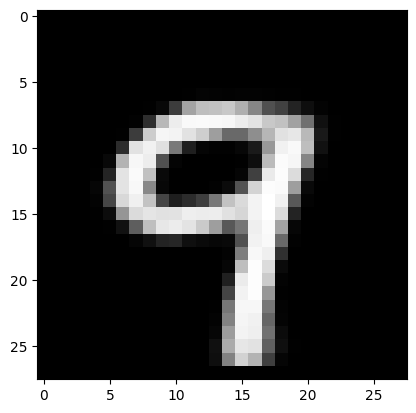

In [4]:
# Define hyperparameters
num_epochs = 180
learning_rate = 0.0001
device='cpu'
vae_kl_w = 1e-3
disc_w = 1e-4
triplet_w = 1e-6
# triplet_w = 0
# mse_w = 1.0
mse_w = 1.0
#disc_mul_every_epoch=1
disc_mul_every_epoch = 1/np.power(disc_w, 1/(num_epochs-1))
triplet_mul_every_epoch = 1/np.power(triplet_w, 1e-3/(num_epochs-1))
#triplet_mul_every_epoch=1
print(f"{triplet_mul_every_epoch=}, {disc_mul_every_epoch=}")

# Initialize the model
model = VAE_GAN().to(device)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer_dec = optim.Adam(model.discriminator.parameters(), lr=learning_rate)

triplet_criterion = nn.TripletMarginLoss(margin=1.0, p=2.0, eps=1e-06)

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        labels = labels.to(device)
        images = images.to(device).view(images.size(0), -1)
        # Forward pass
        mu, log_var, z, x_recon = model(images)
        # negative sample
        if triplet_w > 0:
            m = (labels.unsqueeze(1) == labels)
            rand_shift = torch.randint(1, m.size(0), m.size(), device=m.device)
            pos_indices = torch.max(rand_shift * m, axis=-1).indices
            neg_indices = torch.max(rand_shift * ~m, axis=-1).indices
            mu_log_var = torch.concatenate((mu, log_var), dim=-1)
            positive = mu_log_var[pos_indices].detach()
            negative = mu_log_var[neg_indices].detach()
            # triplet for latent space vector
            triplet_loss = triplet_criterion(mu_log_var, positive, negative)
        else:
            triplet_loss = 0
        # Compute the losses
        kl_div = torch.mean(-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim = 1))
        with torch.no_grad():
            dics = model.discriminate(x_recon)
        disc_loss = - torch.log(dics).mean()
        mse_loss = nn.functional.mse_loss(x_recon, images)

        loss = (  vae_kl_w* kl_div  +
            disc_w * disc_loss +
            triplet_w * triplet_loss
            + mse_w* mse_loss
        )

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer_dec.zero_grad()
        disc_up_loss = - torch.mean(torch.log(model.discriminate(images)) + torch.log(1 - model.discriminate(x_recon.detach())))
        disc_up_loss.backward()
        optimizer_dec.step()



        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}, kl_div={kl_div.item()}, disc={disc_loss.item()}, disc_up={disc_up_loss.item()}, triplet={triplet_loss.item()}, tw={triplet_w}, mse={mse_loss.item()}')
    triplet_w *= triplet_mul_every_epoch
    disc_w *= disc_mul_every_epoch
    print(f"{triplet_w=}, {disc_w=}")

# Generate samples
sample = torch.randn(1, 100, device=device)
generated_img = model.decode(sample).view(28, 28).detach().cpu().numpy()

# Display the generated image
plt.imshow(generated_img, cmap='gray')
plt.show()

In [ ]:
torch.save(model, "vaegun140.pt")
#model = torch.load("mse80.pt")

In [10]:
torch.save(model, "drive/MyDrive/vaegun180.pt")


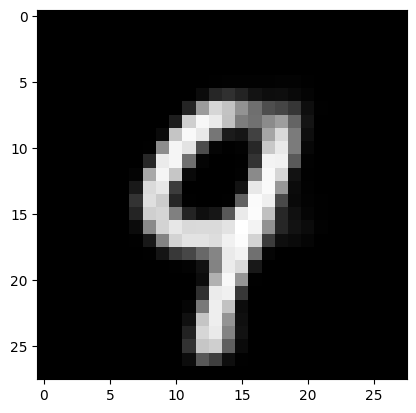

In [27]:
# Generate samples
sample = torch.rand(1, 100, device=device)
generated_img = model.decode(sample).view(28, 28).detach().cpu().numpy()

# Display the generated image
plt.imshow(generated_img, cmap='gray')
plt.show()

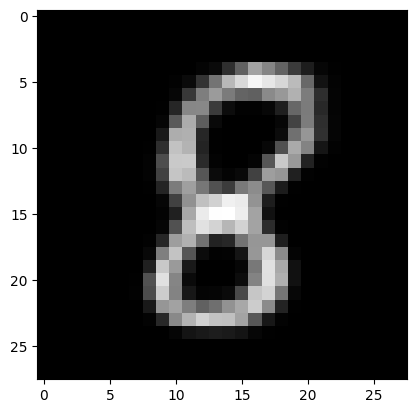

In [32]:
# Generate samples
sample = torch.rand(1, 100, device=device)
mu = model.mu(sample)
log_var = model.log_var(sample)
z = model.reparameterize(mu, log_var)
generated_img = model.decode(z).view(28, 28).detach().cpu().numpy()

# Display the generated image
plt.imshow(generated_img, cmap='gray')
plt.show()


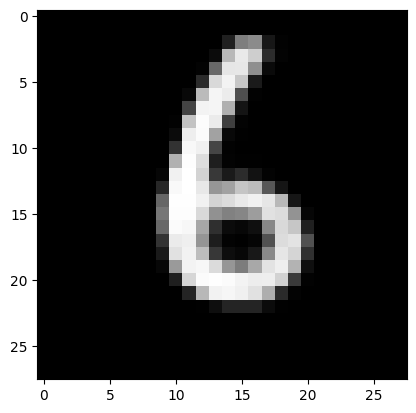

In [24]:
mu, log_var, z, x_recon = model(images)
plt.imshow(x_recon[0].view(28, 28).detach().cpu().numpy(), cmap='gray')
